In [1]:
import random
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
CFG = {
    'X_RANGE':3, # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
    'EPOCHS':500,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':128,
    'SEED':41
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [5]:
train_df = pd.read_csv('weather1.csv',encoding="cp949")
train_df['일시'] = pd.to_numeric(train_df['일시'].str.replace('-','',))
train_df.head()

,지점,지점명,일시,평균기온(°C),일강수량(mm),최대 풍속(m/s),평균 상대습도(%),가조시간(hr),합계 일조시간(hr),합계 일사량(MJ/m2),일 최심적설(cm),평균 전운량(1/10),평균 지면온도(°C)
0,108,서울,20180101,-1.3,NaN,3.8,39.1,9.6,8.3,6.14,NaN,1.0,-1.7
1,108,서울,20180102,-1.8,NaN,4.9,42.0,9.6,7.9,5.36,NaN,2.3,-2.3
2,108,서울,20180103,-4.7,NaN,3.5,42.3,9.7,8.6,6.56,NaN,3.6,-3.4
3,108,서울,20180104,-4.7,NaN,3.5,43.0,9.7,6.2,4.73,NaN,6.5,-3.3
4,108,서울,20180105,-3.0,NaN,3.6,48.4,9.7,8.2,5.96,NaN,3.6,-2.6


In [6]:
train_df = train_df.fillna(0)
train_df = train_df.drop(['최대 풍속(m/s)', '일 최심적설(cm)', '평균 전운량(1/10)','지점','지점명'],axis = 1)
train_df.head()

,일시,평균기온(°C),일강수량(mm),평균 상대습도(%),가조시간(hr),합계 일조시간(hr),합계 일사량(MJ/m2),평균 지면온도(°C)
0,20180101,-1.3,0.0,39.1,9.6,8.3,6.14,-1.7
1,20180102,-1.8,0.0,42.0,9.6,7.9,5.36,-2.3
2,20180103,-4.7,0.0,42.3,9.7,8.6,6.56,-3.4
3,20180104,-4.7,0.0,43.0,9.7,6.2,4.73,-3.3
4,20180105,-3.0,0.0,48.4,9.7,8.2,5.96,-2.6


In [7]:
def get_view_df(df, target):
    viewd = df[['일시', target]]
    viewd = viewd.reset_index(drop=True)
    viewd = viewd.reset_index()
    print(target)
    sns.set(rc = {'figure.figsize':(30,8)})
    sns.lineplot(x='index', y=target, data=viewd)
    plt.show()

In [8]:
train_df.columns

Index(['일시', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)', '가조시간(hr)', '합계 일조시간(hr)',
       '합계 일사량(MJ/m2)', '평균 지면온도(°C)'],
      dtype='object')

평균기온(°C)


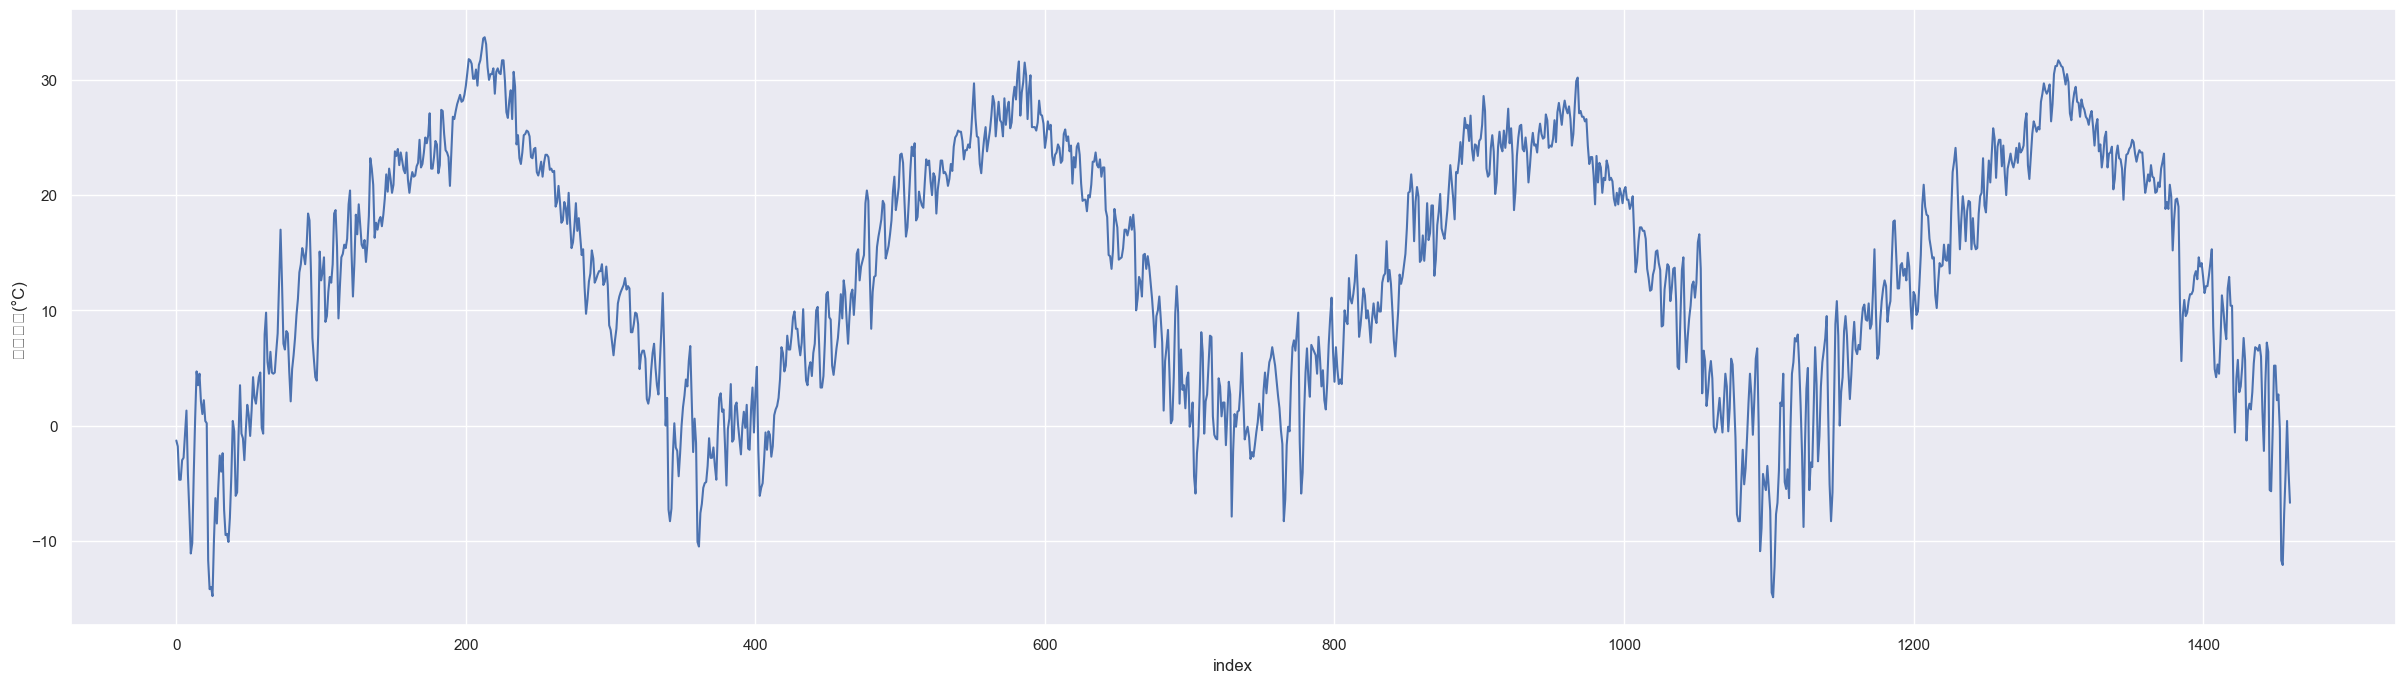

일강수량(mm)


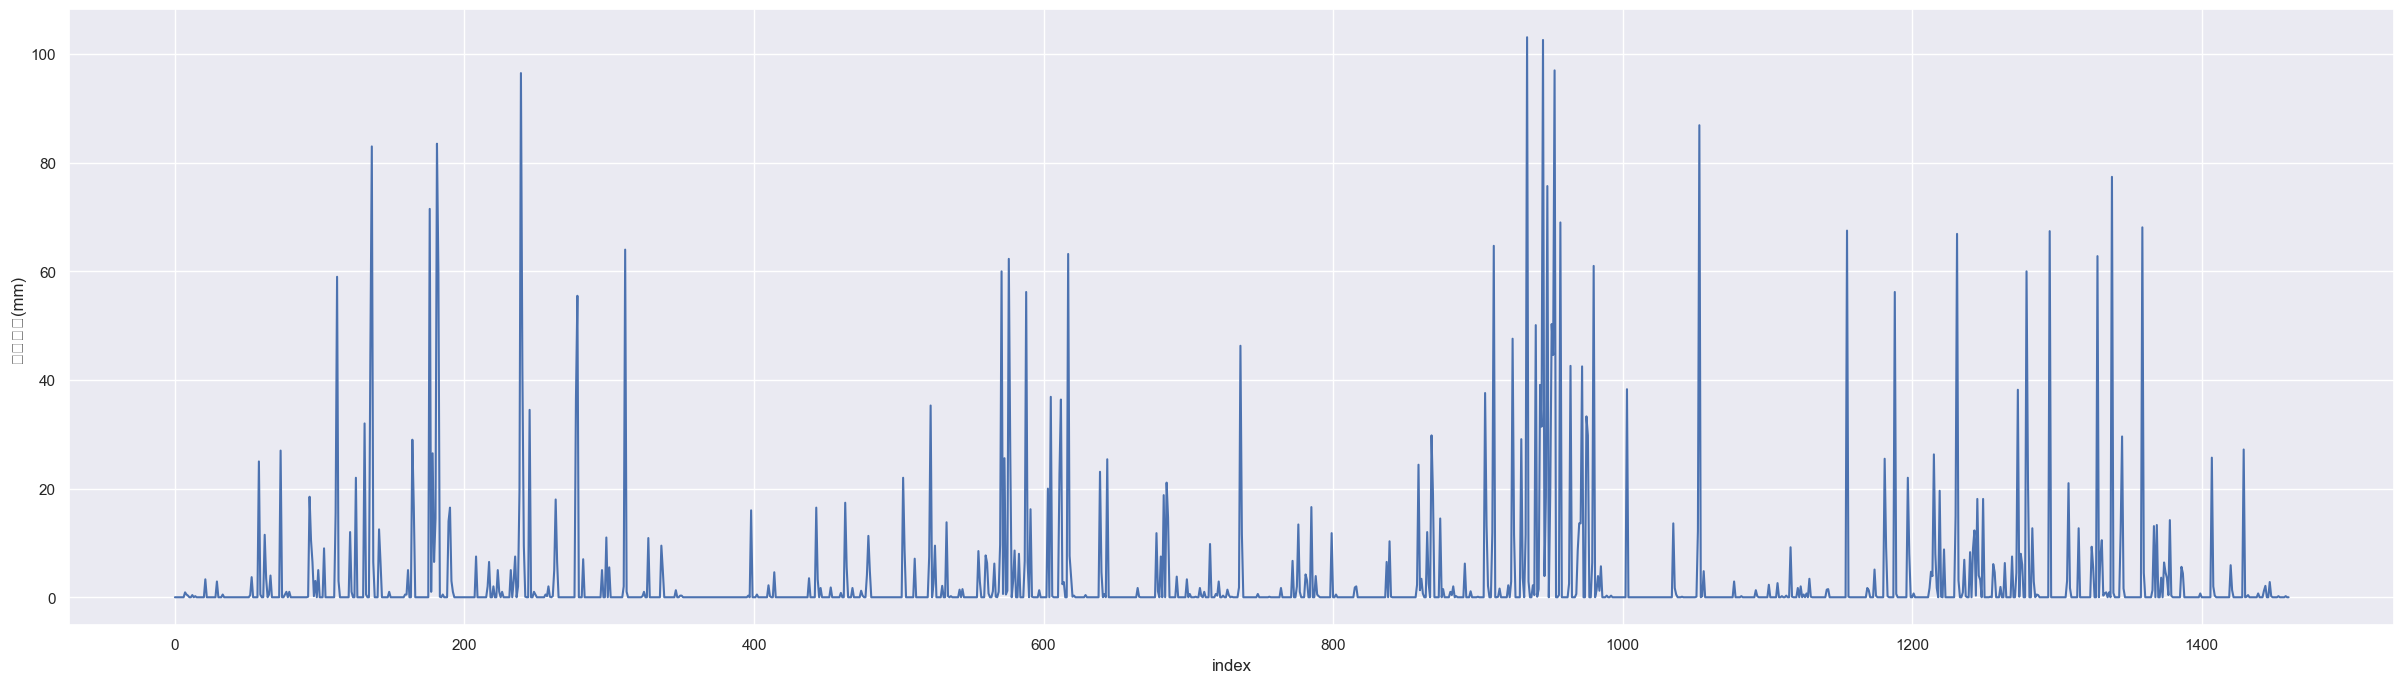

평균 상대습도(%)


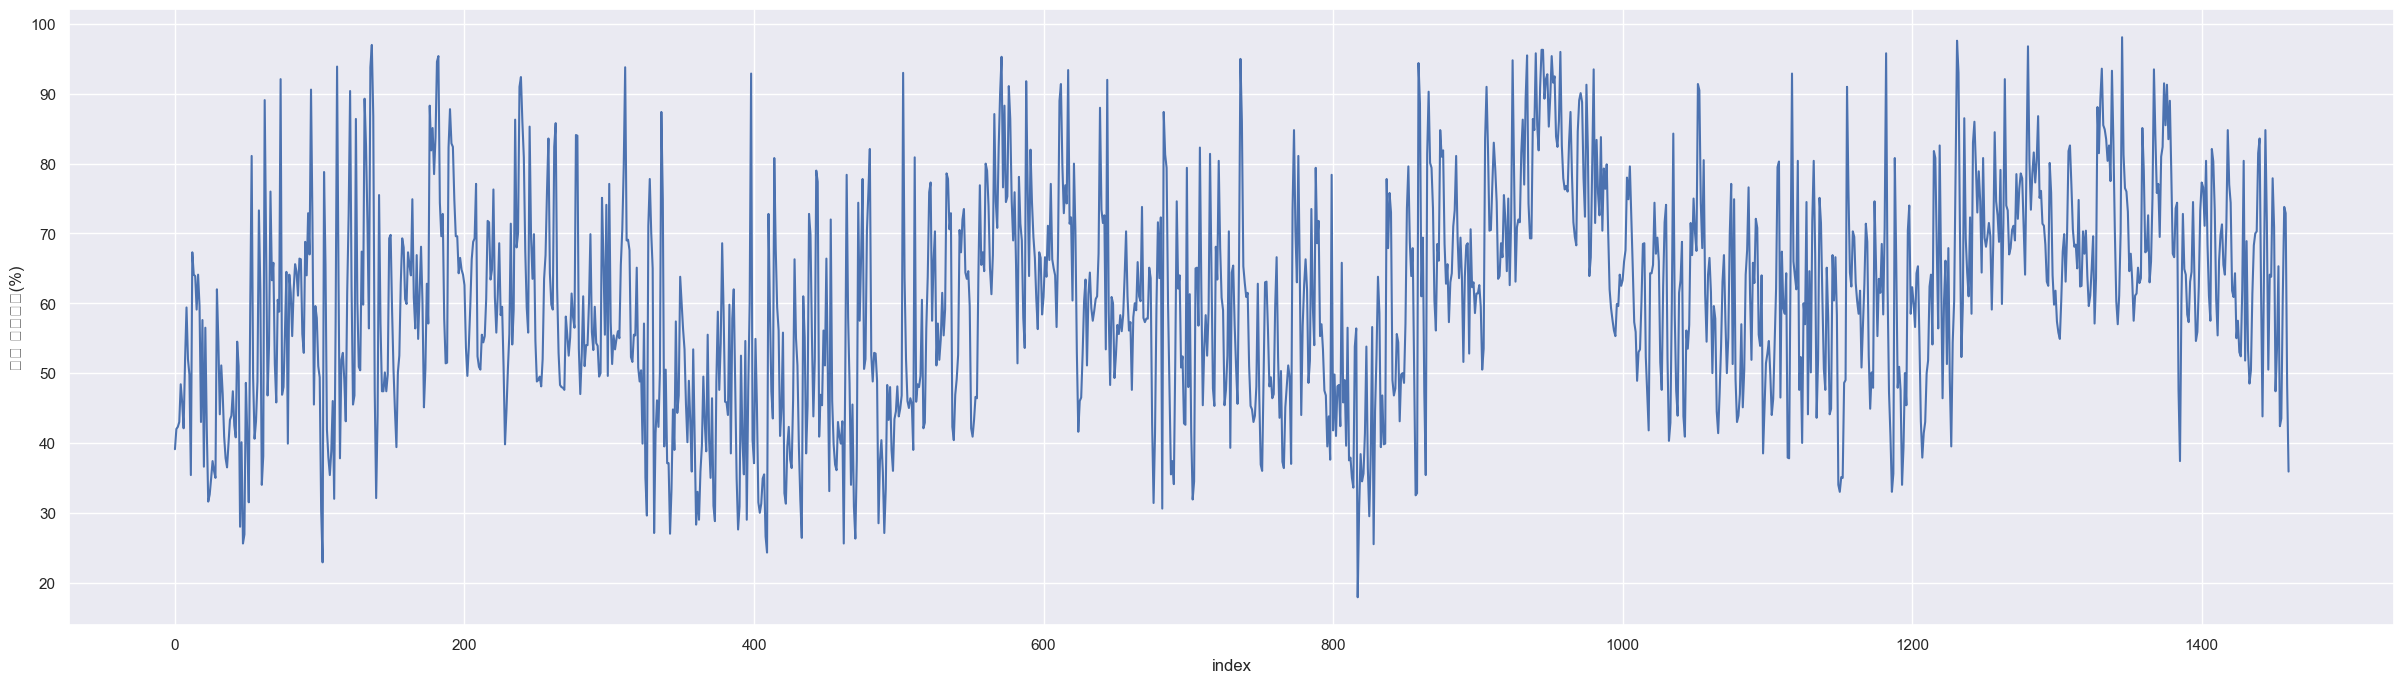

가조시간(hr)


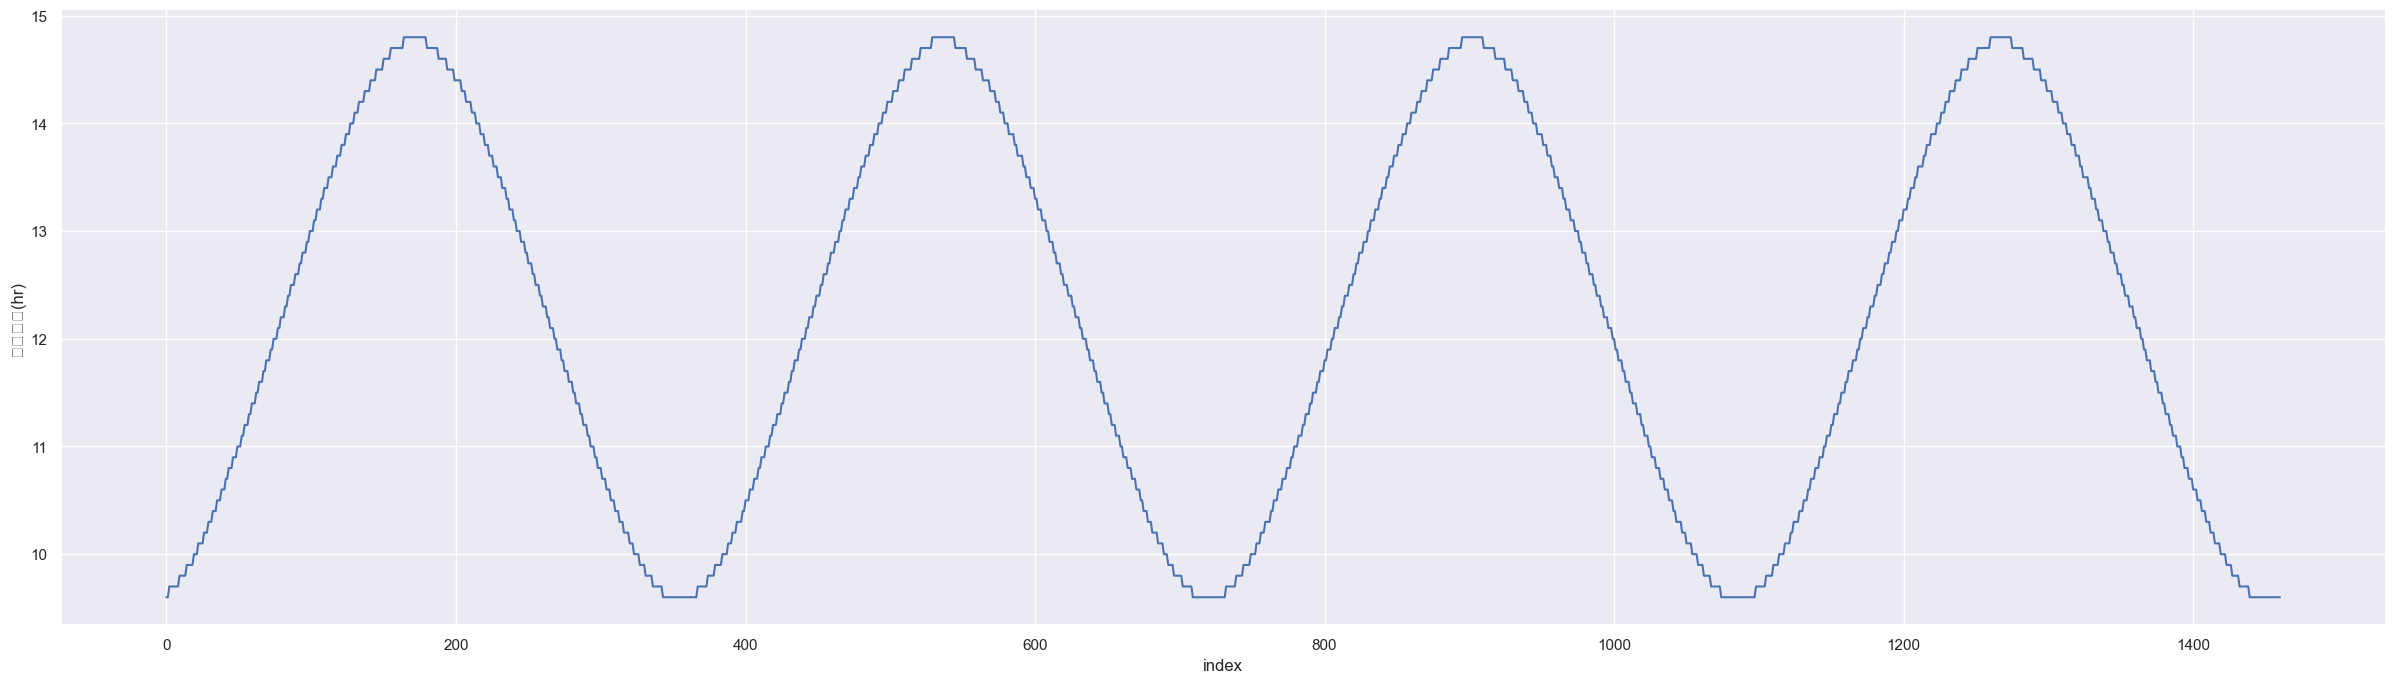

합계 일조시간(hr)


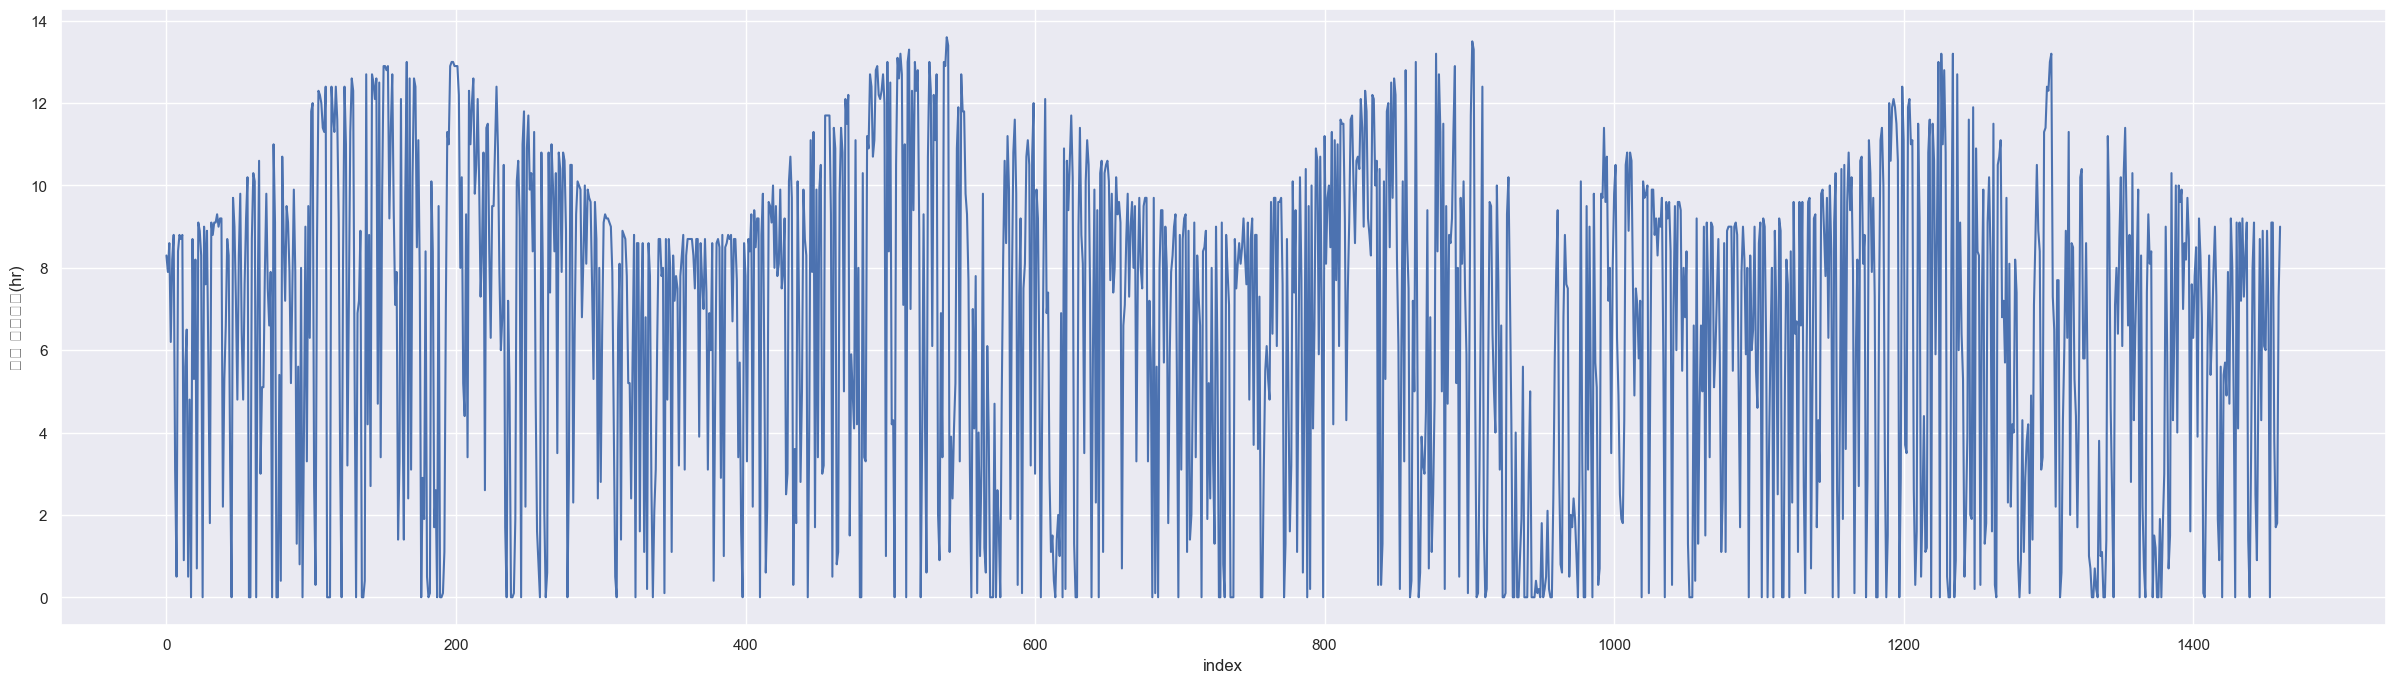

합계 일사량(MJ/m2)


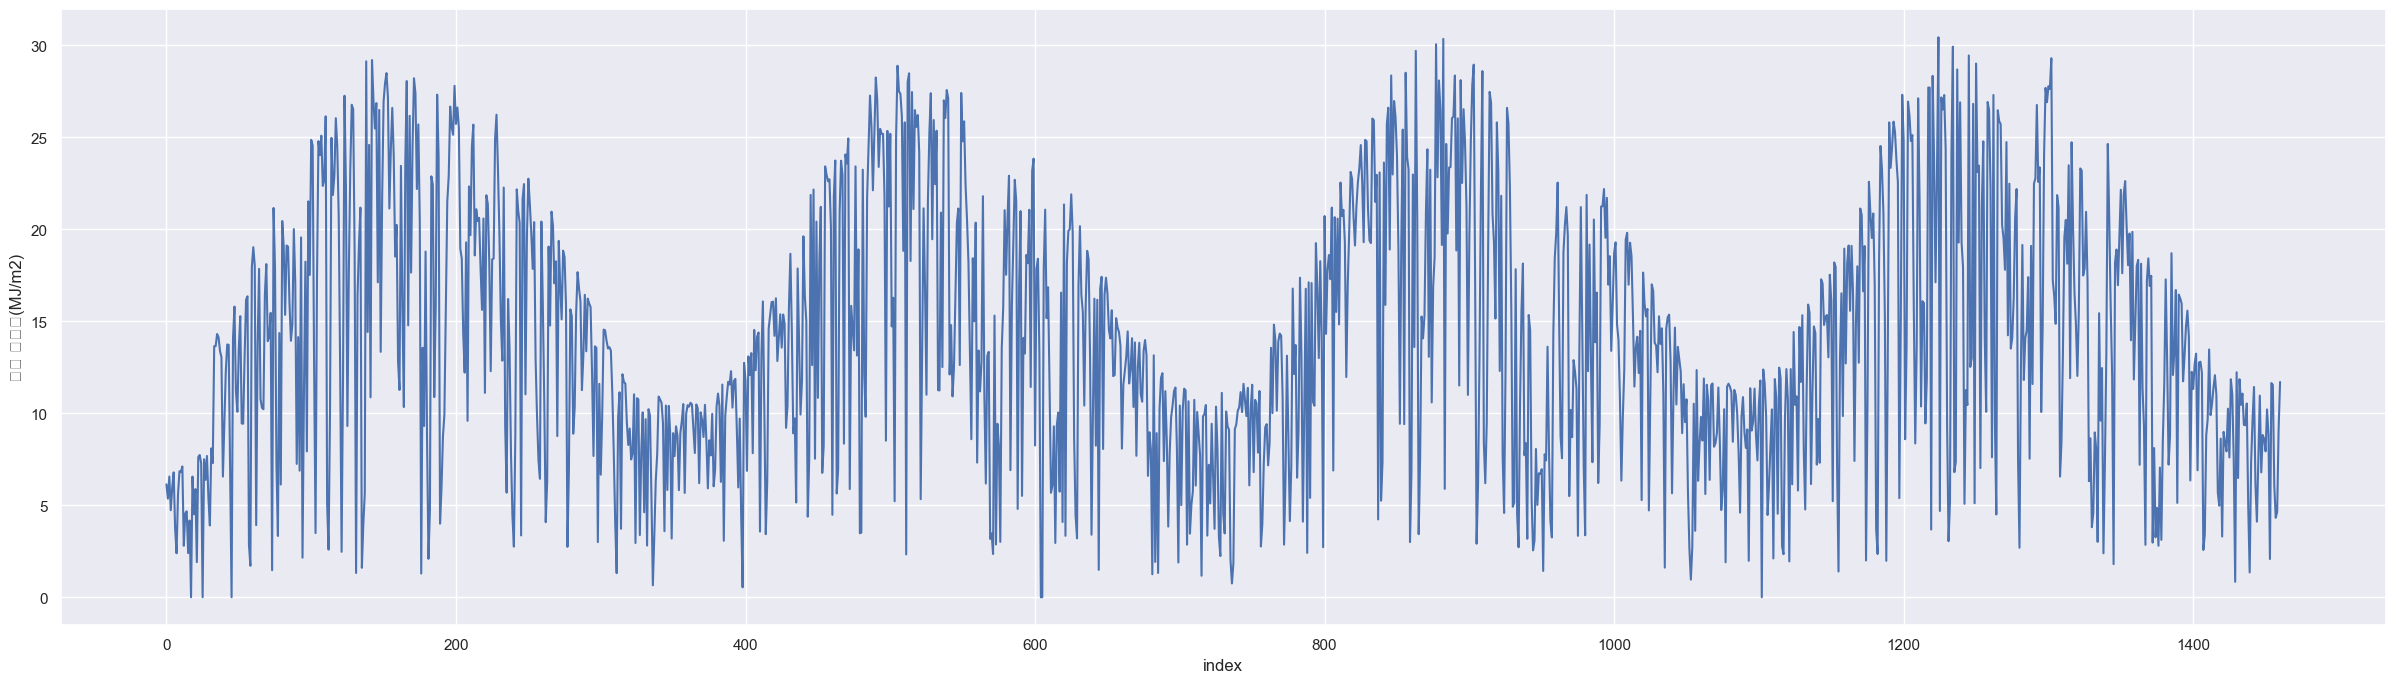

평균 지면온도(°C)


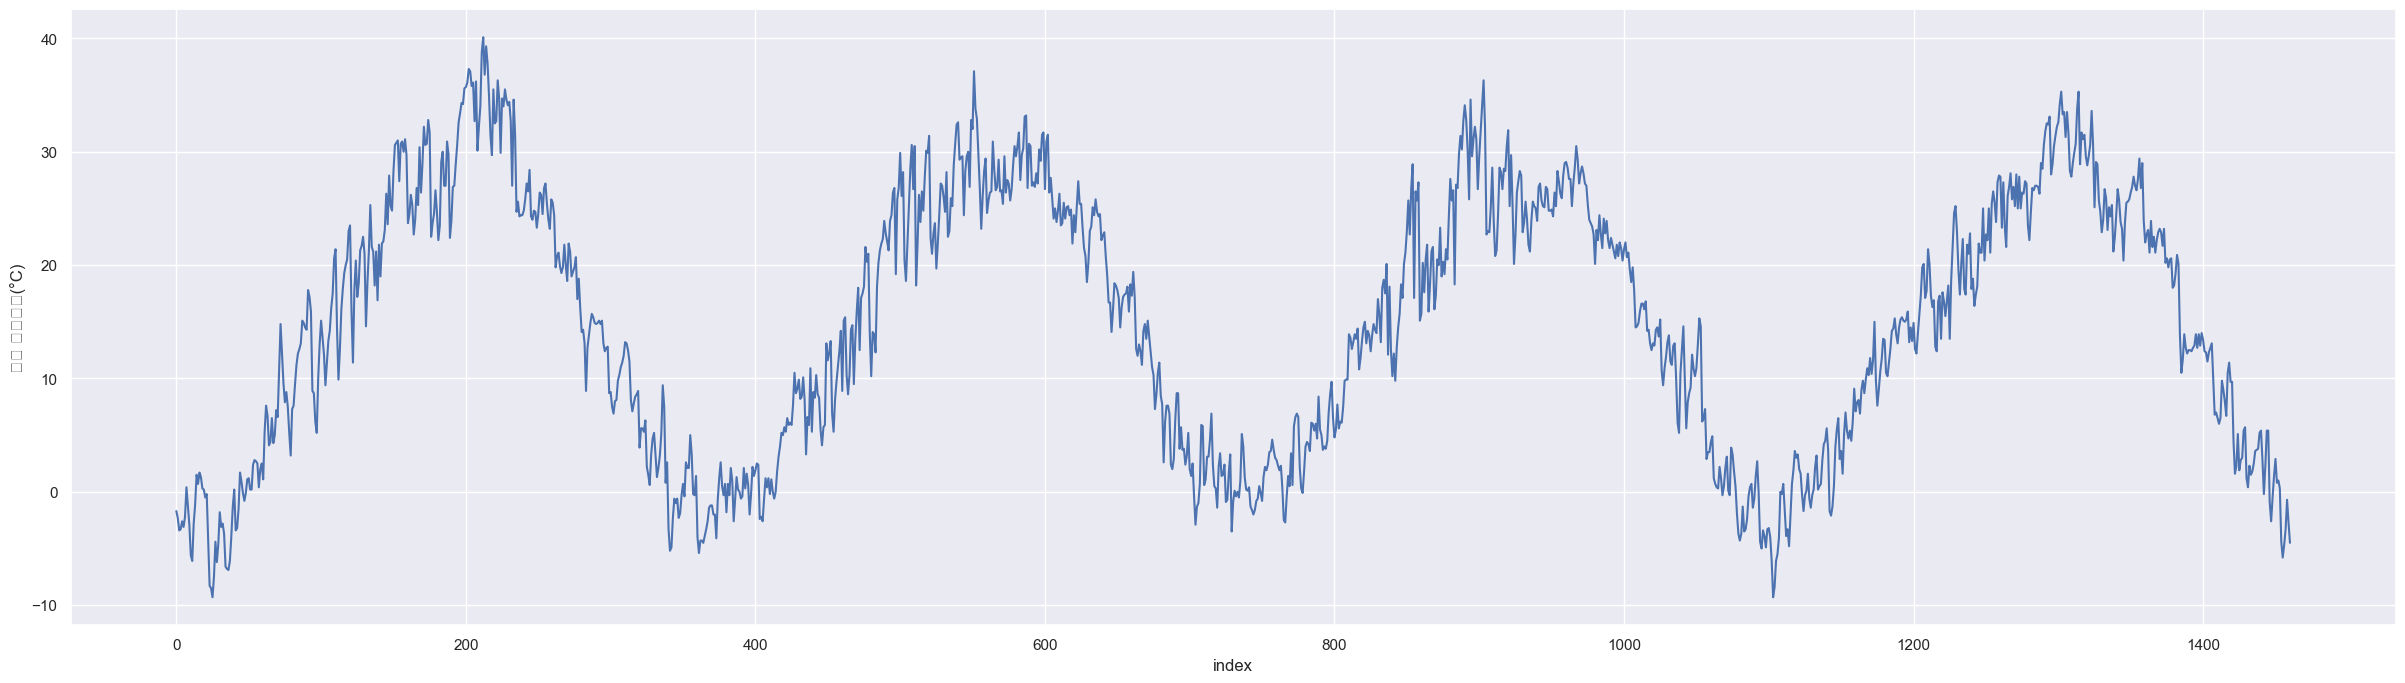

In [9]:
# get_view_df(train_df, '일시')
get_view_df(train_df, '평균기온(°C)')
get_view_df(train_df, '일강수량(mm)')
get_view_df(train_df, '평균 상대습도(%)')
get_view_df(train_df, '가조시간(hr)')
get_view_df(train_df, '합계 일조시간(hr)')
get_view_df(train_df, '합계 일사량(MJ/m2)')
get_view_df(train_df, '평균 지면온도(°C)')

In [10]:
val_df = train_df.iloc[1096-CFG['X_RANGE']:].reset_index().drop(columns='index') # 20210101 ~ 20211231
# 위의 1096-CFG['X_RANGE']의 이유는 20210101을 예측하기 위해서는 이전 X_RANGE만큼의 일수가 필요하므로
train_df = train_df.iloc[:1096].reset_index().drop(columns='index') # 20180101 ~ 20201231

In [11]:
def get_x_y_data(df, infer=False):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []
    y_data = []
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, ['년', '월', '일', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)', '가조시간(hr)', '합계 일조시간(hr)', '합계 일사량(MJ/m2)', '평균 지면온도(°C)']]).astype(float))
        y_data.append(np.array(df.loc[i, ['평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)', '가조시간(hr)', '합계 일조시간(hr)', '합계 일사량(MJ/m2)', '평균 지면온도(°C)']]).astype(float))
    if infer:
        return x_data
    else:
        return x_data, y_data

In [12]:
def make_ymd_feature(df):
    df['일시'] = df['일시'].astype(str)
    df['년'] = df['일시'].str[:4].astype(int)/1000.
    df['월'] = df['일시'].str[4:6].astype(int)/12.
    df['일'] = df['일시'].str[6:8].astype(int)/31.
    df = df[['년', '월', '일', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)', '가조시간(hr)', '합계 일조시간(hr)', '합계 일사량(MJ/m2)', '평균 지면온도(°C)']]
    return df

In [13]:
train_df = make_ymd_feature(train_df)
val_df = make_ymd_feature(val_df)

In [14]:
train_x, train_y = get_x_y_data(train_df)

  0%|          | 0/1093 [00:00<?, ?it/s]

In [15]:
val_x, val_y = get_x_y_data(val_df)

  0%|          | 0/365 [00:00<?, ?it/s]

In [16]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        else:
            return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [17]:
train_dataset = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [18]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=10, hidden_size=256, num_layers=4, batch_first=True)
        
        self.multioutput_reg = nn.Sequential(
            nn.Linear(in_features=256, out_features=128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=7),
        )
        
    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.multioutput_reg(hidden[:,-1,:])
        return output

In [19]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.L1Loss().to(device)
    
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for X, Y in iter(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        val_mae = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{_train_loss:.5f}] Val MAE : [{val_mae:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_mae)
            
        if best_loss > val_mae:
            best_loss = val_mae
            best_model = model 
    return best_model

In [20]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X, Y in iter(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss    

In [21]:
model = BaseModel()

In [22]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4,threshold_mode='abs',min_lr=1e-8, verbose=True)
best_model = train(model, optimizer, train_loader, val_loader, scheduler, device) # 2018.01.01 ~ 2020.12.31 까지 데이터로 학습

Epoch : [1] Train Loss : [16.14031] Val MAE : [12.66095]
Epoch : [2] Train Loss : [12.14301] Val MAE : [11.07266]
Epoch : [3] Train Loss : [9.76817] Val MAE : [9.53457]
Epoch : [4] Train Loss : [7.82304] Val MAE : [7.52586]
Epoch : [5] Train Loss : [7.56087] Val MAE : [5.76461]
Epoch : [6] Train Loss : [7.31555] Val MAE : [6.01561]
Epoch 00006: reducing learning rate of group 0 to 5.0000e-03.
Epoch : [7] Train Loss : [4.94313] Val MAE : [4.70648]
Epoch : [8] Train Loss : [4.74709] Val MAE : [4.71182]
Epoch : [9] Train Loss : [4.86392] Val MAE : [5.30000]
Epoch : [10] Train Loss : [4.80020] Val MAE : [4.89729]
Epoch : [11] Train Loss : [5.10447] Val MAE : [4.67339]
Epoch 00011: reducing learning rate of group 0 to 2.5000e-03.
Epoch : [12] Train Loss : [4.42070] Val MAE : [4.43452]
Epoch : [13] Train Loss : [4.60900] Val MAE : [4.55687]
Epoch : [14] Train Loss : [4.46653] Val MAE : [4.43814]
Epoch : [15] Train Loss : [4.33400] Val MAE : [5.16611]
Epoch : [16] Train Loss : [4.84311] Val M

In [27]:
test_df = pd.read_csv('wt.csv',encoding='cp949')
test_df = make_ymd_feature(test_df)
test_df = pd.concat([val_df[CFG['X_RANGE']*(-1):], test_df]).reset_index().drop(columns='index')

In [28]:
test_df.head()

,년,월,일,평균기온(°C),일강수량(mm),평균 상대습도(%),가조시간(hr),합계 일조시간(hr),합계 일사량(MJ/m2),평균 지면온도(°C)
0,2.021,1.000000,0.935484,0.4,0.2,72.9,9.6,1.8,4.64,-0.7
1,2.021,1.000000,0.967742,-3.9,0.0,48.5,9.6,7.3,9.14,-2.7
2,2.021,1.000000,1.000000,-6.7,0.0,35.9,9.6,9.0,11.70,-4.5
3,2.022,0.083333,0.032258,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.022,0.083333,0.064516,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
def inference(model, df, device):
    model.to(device)
    model.eval()
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        X = torch.Tensor(np.array(df.loc[i-CFG['X_RANGE']:i-1, ['년', '월', '일', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)', '가조시간(hr)', '합계 일조시간(hr)', '합계 일사량(MJ/m2)', '평균 지면온도(°C)']]).astype(float)).unsqueeze(0)
        X = X.to(device)
        with torch.no_grad():
            model_pred = model(X)[0]
        
        model_pred = model_pred.cpu().numpy()
        df.loc[i, ['평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)', '가조시간(hr)', '합계 일조시간(hr)', '합계 일사량(MJ/m2)', '평균 지면온도(°C)']] = model_pred
    return df.loc[CFG['X_RANGE']:, ['평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)', '가조시간(hr)', '합계 일조시간(hr)', '합계 일사량(MJ/m2)', '평균 지면온도(°C)']].reset_index().drop(columns=['index'])

In [30]:
preds = inference(best_model, test_df, device)

  0%|          | 0/334 [00:00<?, ?it/s]

In [31]:
submit = pd.read_csv('wt.csv',encoding='cp949')
submit.head()

,일시,평균기온(°C),일강수량(mm),평균 상대습도(%),가조시간(hr),합계 일조시간(hr),합계 일사량(MJ/m2),평균 지면온도(°C)
0,20220101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20220102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20220103,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20220104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20220105,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
submit['평균기온(°C)'] = preds['평균기온(°C)'].round(1)
submit['일강수량(mm)'] = preds['일강수량(mm)'].round(1)
submit['평균 상대습도(%)'] = preds['평균 상대습도(%)'].round(1)
submit['가조시간(hr)'] = preds['가조시간(hr)'].round(1)
submit['합계 일조시간(hr)'] = preds['합계 일조시간(hr)'].round(1)
submit['합계 일사량(MJ/m2)'] = preds['합계 일사량(MJ/m2)'].round(1)
submit['평균 지면온도(°C)'] = preds['평균 지면온도(°C)'].round(1)

In [33]:
submit

,일시,평균기온(°C),일강수량(mm),평균 상대습도(%),가조시간(hr),합계 일조시간(hr),합계 일사량(MJ/m2),평균 지면온도(°C)
0,20220101,-2.6,-0.0,46.4,9.6,8.0,8.7,-2.9
1,20220102,-1.8,0.0,47.3,9.8,8.0,9.0,-2.0
2,20220103,-1.6,0.0,47.5,9.9,8.0,9.0,-1.9
3,20220104,-1.1,0.0,47.9,9.9,8.0,9.2,-1.3
4,20220105,-0.6,0.0,48.3,10.0,8.0,9.3,-0.8
...,...,...,...,...,...,...,...,...
329,20221126,12.0,0.0,58.2,11.6,7.4,12.8,12.6
330,20221127,12.1,0.0,58.2,11.6,7.4,12.9,12.8
331,20221128,11.9,0.0,58.0,11.6,7.4,12.8,12.6
332,20221129,11.4,0.0,57.6,11.5,7.4,12.6,12.0


In [34]:
submit.to_csv('wt_model.csv', index=False)